## Example of Primer oscillator (Pytorch).
Use normal neural networks (NN) and physics-informed neural network (PINN) to solve Primer oscillator. <br>
The specific equation is as follows:

\begin{equation}
 \frac {du} {dt} + 0.1 u - sin(\pi*t/2) = 0,
 \end{equation}
 with initial condition u(0) = 1.

Used to make Figures X to X in paper.


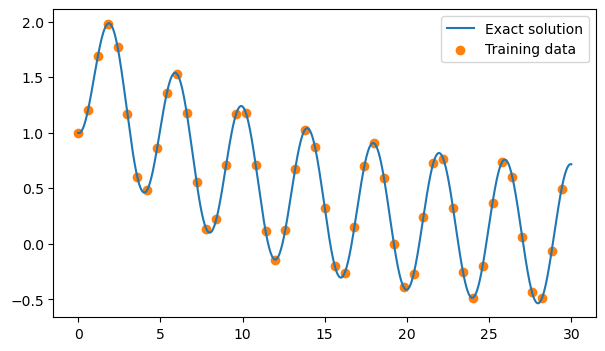

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def oscillatorb():
    nSteps=3000
    tMin,tMax = 0.0,30.0
    
    tStep = (tMax-tMin)/nSteps
    tPoints = np.arange(tMin, tMax, tStep)
    
    y0 = 1.0
    y = [y0]

    for t in tPoints[1:]:
        tdemi= t - tStep/2.
        ydemi = y[-1] + tStep/2.*( - 0.1*y[-1] + np.sin(np.pi*tdemi/2))        
        y.append(y[-1] + tStep * (- 0.1*ydemi + np.sin(np.pi*t/2)))  
        
    y = torch.Tensor(y)

    return torch.Tensor(tPoints).view(-1, 1), torch.Tensor(y).view(-1, 1)


class FCN(nn.Module):

    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x
    
x, y = oscillatorb()
x = x[::1]
y = y[::1]

x_data=x[0:3000:60] # 119
y_data=y[0:3000:60]

plt.figure(figsize=(7, 4))
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

## Normal neural network

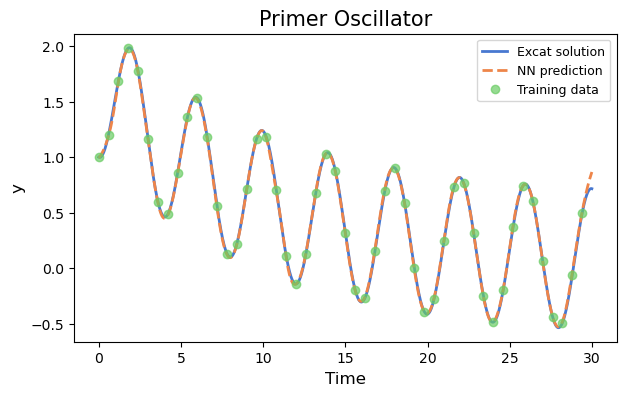

In [4]:
import time
import seaborn as sns

torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=3e-3)
files = []
loss11_history = []

# start_time = time.time()

for i in range(24000):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)
    loss.backward()
    optimizer.step()
    loss11_history.append(loss.detach()) 

# end_time = time.time()
# total_time = end_time - start_time
# print(f"Total training time: {total_time:.2f} seconds")

y_pred = model(x).detach().numpy()

palette = sns.color_palette("muted")
plt.figure(figsize=(7, 4))
plt.plot(x, y, '-', color=palette[0], linewidth=2, label='Excat solution')
plt.plot(x, y_pred, '--', color=palette[1], linewidth=2, label='NN prediction')
plt.plot(x_data, y_data, 'o', color=palette[2], linewidth=2, alpha=0.7, label='Training data')
plt.title('Primer Oscillator', fontsize=15, fontweight='medium')
plt.xlabel('Time', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.legend(frameon=True, loc='upper right', fontsize=9)
plt.show()

## Physical information neural networks

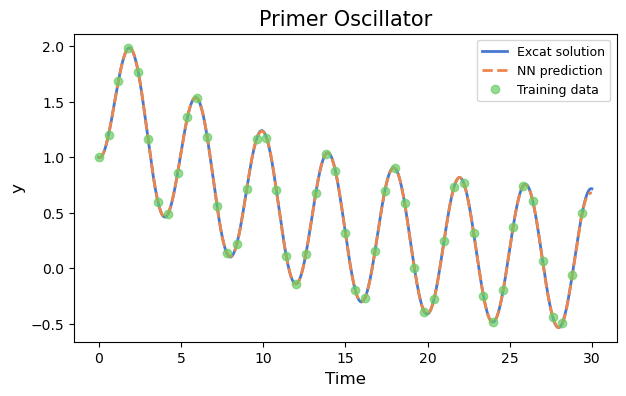

In [9]:
x_physics = torch.linspace(0,30,50).view(-1,1).requires_grad_(True)
lam=0.1

torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=3e-3)
files = []

loss_history = []
loss2_history = []

# start_time = time.time()

for i in range(24000):
    optimizer.zero_grad()
    
    yh = model(x_data)
    loss1 = 1.*torch.mean((yh-y_data)**2)

    yhp = model(x_physics)
    dx = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]  

    physics = (dx + lam*yhp - torch.sin(np.pi*x_physics/2))       
    loss2 = (6e-2)*(torch.mean(physics**2))

    loss = loss1 + loss2
    loss.backward()
    optimizer.step()

# end_time = time.time()
# total_time = end_time - start_time
# print(f"Total training time: {total_time:.2f} seconds")

y_pred = model(x).detach().numpy()

palette = sns.color_palette("muted")
plt.figure(figsize=(7, 4))
plt.plot(x, y, '-', color=palette[0], linewidth=2, label='Excat solution')
plt.plot(x, y_pred, '--', color=palette[1], linewidth=2, label='NN prediction')
plt.plot(x_data, y_data, 'o', color=palette[2], linewidth=2, alpha=0.7, label='Training data')
plt.title('Primer Oscillator', fontsize=15, fontweight='medium')
plt.xlabel('Time', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.legend(frameon=True, loc='upper right', fontsize=9)
plt.show()

In [1]:
import torch

if torch.cuda.is_available():
    print("GPU is available.")
    print("Available GPU count:", torch.cuda.device_count())
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available, using CPU instead.")


GPU is available.
Available GPU count: 1
GPU Name: NVIDIA GeForce RTX 3060 Laptop GPU
